In [1]:
import fasttext
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearnex import patch_sklearn

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
patch_sklearn()
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
encoder = fasttext.load_model('../models/encoders/cc.ar.300.bin')

In [5]:
dataset = pd.read_json("../data/processed/to_label.json")
dataset.head()

,tweetid,tweet_text,text,tech,label
0,295735762505322497,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,None,0
1,1080873494227886086,RT @rood516: عرض الاجازه😍👌🏻1\nســــاعه\nقـــلم...,RT : عرض الاجازه1 ســــاعه قـــلم كــبك نظـــا...,None,0
2,1027481525506453504,RT @6FSH1_: مهما ضاق صدرك تذكر أن في ناس توهم ...,RT : مهما ضاق صدرك تذكر أن في ناس توهم بيسجلون...,None,0
3,417202038037299200,RT @f450450: ﴿ياحي ياقيوم برحمتك أستغيث أصلح ل...,RT : ﴿ياحي ياقيوم برحمتك أستغيث أصلح لي شأني ك...,None,0
4,834074569673736193,RT @7744Qa: بعض البشر ، إذا وجد البديل نكر الج...,RT : بعض البشر ، إذا وجد البديل نكر الجميل. قر...,None,0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetid     2100 non-null   int64 
 1   tweet_text  2100 non-null   object
 2   text        2100 non-null   object
 3   tech        202 non-null    object
 4   label       2100 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 98.4+ KB


In [7]:
vectors = []
for t in tqdm(dataset.text.to_list(), total=len(dataset)):
    vectors.append(list(encoder.get_sentence_vector(t)))

dataset["vector"] = vectors

  0%|          | 0/2100 [00:00<?, ?it/s]

In [8]:
label_names = ["transparent", "propaganda"]

In [9]:
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

In [10]:
train, valid = train_test_split(
    dataset, test_size=0.4, random_state=42, stratify=dataset.label
)
valid, test = train_test_split(
    valid, test_size=0.5, random_state=42, stratify=valid.label
)

In [11]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [12]:
test.head()

,tweetid,tweet_text,text,tech,label,vector
0,977553193814122498,شاركوا معنا .. في #ساعة_الأرض الليلة \nساعة وا...,شاركوا معنا .. في ساعة الأرض الليلة ساعة واحد ...,None,0,"[-0.0009555278, 0.0012486062, -0.013509666, 0...."
1,1005856990436970497,RT @qtfcjohz: َاللهم طهر قلوبنا من كل ضيق \nوي...,RT : اللهم طهر قلوبنا من كل ضيق ويسر أمورنا في...,None,0,"[-0.026198564, 0.011223065, -0.03573343, 0.006..."
2,705893711595622400,- 97 يوم . . https://t.co/B4vN1bYT1q,- 97 يوم . .,None,0,"[-0.016985966, 0.023942119, 0.013537327, -0.01..."
3,898256787857604609,RT @soso_ot511: ”اشتقت بصمت أتألم لأكن الله لط...,RT : ”اشتقت بصمت أتألم لأكن الله لطيف بـ القلو...,None,0,"[-0.008837707, 0.0028942337, 0.0024905056, 0.0..."
4,884211704090984448,قالﷺ:\n(من كانت الآخرة همـــه\nجعل الله غناه ف...,قالﷺ: (من كانت الآخرة همـــه جعل الله غناه في ...,None,0,"[-0.020786136, 0.001279178, -0.025478864, 0.04..."


In [13]:
w = train.label.value_counts(normalize=True).to_list()
w = {i: w[i] for i in range(len(w))}
w

{0: 0.903968253968254, 1: 0.09603174603174604}

In [14]:
def objective(trial):
    p = trial.suggest_categorical("penalty", ["l1", "l2"])
    s = trial.suggest_categorical("solver", ["liblinear"])
    c = trial.suggest_categorical("C", [0.1, 1.0, 10.0, 100.0, 1000.0])
    model = LogisticRegression(
        penalty=p, solver=s, C=c, class_weight=w, max_iter=1000, random_state=42
    )
    model.fit(train.vector.to_list(), train.label.to_list())
    # acc = model.score(x_test, y_test)
    f1 = f1_score(
        valid.label.to_list(),
        model.predict(valid.vector.to_list()),
        average="binary",
    )
    return f1

In [15]:
study = optuna.create_study(study_name="baseline", direction="maximize")
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
model = LogisticRegression(class_weight=w, random_state=42, max_iter=1000, **study.best_params)
model.fit(train.vector.to_list(), train.label.to_list())

LogisticRegression(C=1000.0,
                   class_weight={0: 0.903968253968254, 1: 0.09603174603174604},
                   max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [17]:
preds_test = model.predict(test.vector.to_list())

In [18]:
print(
    classification_report(test.label.to_list(), preds_test, target_names=label_names)
)

              precision    recall  f1-score   support

 transparent       0.95      0.95      0.95       380
  propaganda       0.50      0.50      0.50        40

    accuracy                           0.90       420
   macro avg       0.72      0.72      0.72       420
weighted avg       0.90      0.90      0.90       420



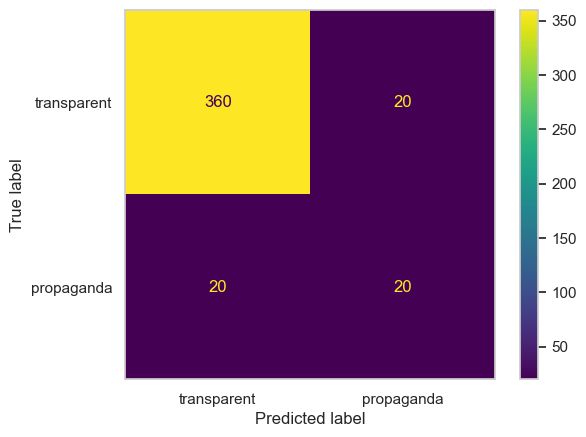

In [19]:
cm = confusion_matrix(test.label.to_list(), preds_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot()
plt.show()